In [0]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import json
import re
from nltk.corpus import stopwords

def tokenize_text(source='long_text.txt'):
  eng_stopwords = stopwords.words("english")
  words = re.findall(r'\w+', open(source).read().lower())
  filtered_words = filter(lambda x: x not in eng_stopwords, words)
  word_dict = {w: i for i, w in enumerate(filtered_words)}
  return word_dict

word_dict = tokenize_text()
print(f"Dictionary size {len(word_dict)}")

Dictionary size 29475


In [0]:
def clear_sentence(sentence):
    for character in [
            "\n", "\"", "\'", "\`", "!", ":", ";", ".", ",", "?", '-', '[',
            ']', "\\", "|", "\t", "#", "-", '(', ')', '{', '}', "”"
    ]:
        sentence = sentence.replace(character, '')
    return sentence

new_sentences = []
with open('./long_text.txt', 'r') as f:
    for line in f:
        if 'http' in line:
            continue
        sents = line.split('.')
        for sent in sents:
            sent = clear_sentence(sent.strip())
            words = sent.split(' ')
            filtered_words = list(filter(lambda x: (x != ' ') and (x != ''), words))
            if len(filtered_words) < 6:
                continue
            new_sentences.append(' '.join(filtered_words).lower())

# print(new_sentences[:150])
print(f"Sentences {len(new_sentences)}")
with open('./sentenced_long_text.txt', 'w') as f:
    for item in new_sentences:
        f.write("%s\n" % item)

Sentences 16159


In [0]:
import multiprocessing 
import time
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence 


w2v = Word2Vec(min_count=15,
               window=5,
               size=300,
               sample=6e-5,
               min_alpha=0.0007, 
               negative=20,
               workers=multiprocessing.cpu_count()-1)

In [0]:
sentences = LineSentence('./sentenced_long_text.txt')
t = time.time()
w2v.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
t = time.time()
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=600, 
                report_delay=1, compute_loss=True)
print(f"Time to train the model: {round((time.time() - t) / 60, 2)} mins")
print(f"Loss {w2v.get_latest_training_loss()}")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Time to train the model: 6.78 mins
Loss 62690936.0


In [0]:
wv = w2v.wv

In [0]:
import numpy as np 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

genres_prop = ['renaissance', 'surrealism', 'constructivism', 'modernism', 'baroque',
          'cubism', 'impressionism', 'minimalism', 'classicism', 'graffiti']
genres = []
genre_vectors = []
for genre in genres_prop:
  try:
    genre_vectors.append(wv[genre])
    genres.append(genre)
  except KeyError:
    print(f"Genre {genre} is missing from the vocab.")
    len_gen -= 1

genre_vectors = np.array(genre_vectors)


painters_prop = ['picasso', 'monet', 'rembrandt', 'vinci', 
                 'frida', 'michelangelo', 'caravaggio', 'rubens',
                  'banksy']
painter_vectors = []
painters = []
for painter in painters_prop:
  try:
    painter_vectors.append(wv[painter])
    painters.append(painter)
  except KeyError:
    print(f"Painter {painter} is missing from the vocab.")
  
painter_vectors = np.array(painter_vectors)
vectors = np.concatenate([genre_vectors, painter_vectors])

Genre constructivism is missing from the vocab.
Genre minimalism is missing from the vocab.
Genre classicism is missing from the vocab.
Painter monet is missing from the vocab.
Painter vinci is missing from the vocab.
Painter frida is missing from the vocab.
Painter caravaggio is missing from the vocab.
Painter rubens is missing from the vocab.


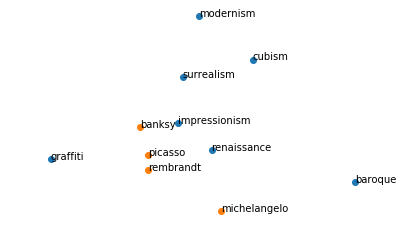

In [0]:
import matplotlib.pyplot as plt 

len_gen = len(genres)

tsne = TSNE(n_components=2, perplexity=35)
pca = PCA(n_components=2)
Y = tsne.fit_transform(vectors)
Y = pca.fit_transform(vectors)

plt.scatter(Y[:len_gen, 0], Y[:len_gen, 1])
plt.scatter(Y[len_gen:, 0], Y[len_gen:, 1])
for i, txt in enumerate(genres):
  plt.annotate(txt, (Y[i,0], Y[i, 1]))
for i, txt in enumerate(painters):
  plt.annotate(txt, (Y[i + len_gen,0], Y[i+len_gen, 1]))

plt.axis('off')
plt.show()

In [0]:
for painter in painters_prop:
  mst_sml = 0 
  mst_sml_lab = None
  for genre in genres_prop:
    try:
      smlr = wv.similarity(painter, genre)
    except KeyError: continue
    if smlr > mst_sml:
      mst_sml = smlr
      mst_sml_lab = genre
  if mst_sml_lab is not None:
    print(f"Painter {painter}, most_similar {mst_sml_lab}")

Painter picasso, most_similar surrealism
Painter rembrandt, most_similar renaissance
Painter michelangelo, most_similar baroque
Painter banksy, most_similar graffiti


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
